In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import os

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, RandomResizedCrop, RandomRotation
from tqdm import tqdm

import datetime
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from Module.models.timm_image_encoder import TimmImageEncoder
from Module.dataset.image_folder import ImageFolder

from mobile_sam import SamPredictor, sam_model_registry
from mobile_sam.modeling.sam import Sam

from Module.utils.text_writer import TextWriter
from Module.utils.util import get_device
from Module.trainer.distillation import one_epoch_distill, one_epoch_val

C:\Users\danusys\anaconda3\envs\nanosam\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\danusys\anaconda3\envs\nanosam\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
C:\Users\danusys\anaconda3\envs\nanosam\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
C:\Users\danusys\anaconda3\envs\nanosam\lib\site-packages\timm\models\registry.py:4: FutureWarning: Import

## Config setting

In [3]:
setting = {}

lr = 3e-4
bs = 4
N_epoch = 100

setting["train"] = {}
setting["train"]["learning_rate"] = lr
setting["train"]["batch_size"] = bs
setting["train"]["epochs"] = N_epoch

device = get_device()
setting["device"] = device.type

## Models
### Teacher model

In [4]:
model_t_type = 'vit_b'
checkpoint_t = '../runs/241115_SAM_ViT_b_dataset_V2_ft_v1/best.pth'

model_t = sam_model_registry[model_t_type](checkpoint=checkpoint_t)
model_t.to(device)
model_t.eval();

In [5]:
setting["Teacher_model"] = {}
setting["Teacher_model"]["type"] = model_t_type
setting["Teacher_model"]["checkpoint"] = checkpoint_t

### Student model

In [6]:
setting["Student_model"] = {}

model_s_type = 'resnet18'
setting["Student_model"]["type"] = model_s_type


if model_s_type=="resnet18":
    model_s=TimmImageEncoder(model_s_type, pretrained=True)
elif model_s_type=="vit_t":
    checkpoint_s = '../Weights/mobile_samv2/mobile_sam.pt'
    model_s = sam_model_registry[model_type_t](checkpoint=checkpoint_s)
    
model_s.to(device)
model_s.train();

## Dataset


### Train dataset

### Transform

In [7]:
transform = A.Compose([
    A.ColorJitter(p=0.7),
    A.RandomResizedCrop((1024, 1024)),
    A.Rotate((-90,90)),
    A.RandomGridShuffle(p=0.8),
    A.Normalize(
        mean=[123.675/255, 116.28/255, 103.53/255],
        std=[58.395/255, 57.12/255, 57.375/255]
    ),
    ToTensorV2(),
    ])

In [8]:
train_dataset_dir = r"D:\WaterSegmentation\Datasets\DANU_WS_v2\train\images"

In [9]:
train_dataset = ImageFolder(train_dataset_dir, 
                            transform=transform)

In [10]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=bs, num_workers=8)

In [11]:
setting["Train_dataset"] = {}
setting["Train_dataset"]["Directory"] = train_dataset_dir
setting["Train_dataset"]["shuffle"] = True
setting["Train_dataset"]["Augmentation"] = A.to_dict(transform)

### Val dataset

In [12]:
val_transform = A.Compose([
    A.Resize(height=1024, width=1024, p=1),
    A.Normalize(
        mean=[123.675/255, 116.28/255, 103.53/255],
        std=[58.395/255, 57.12/255, 57.375/255]
    ),
    ToTensorV2(),
    ])

In [13]:
val_dataset_dir = r"D:\WaterSegmentation\Datasets\DANU_WS_v1\valid\images"

In [14]:
val_dataset = ImageFolder(val_dataset_dir, 
                          transform=val_transform)

In [15]:
val_loader = DataLoader(val_dataset, 
                        shuffle=False, 
                        batch_size=1, 
                        num_workers=0)

In [16]:
setting["Validation_dataset"] = {}
setting["Train_dataset"]["Directory"] = val_dataset_dir
setting["Train_dataset"]["shuffle"] = False
setting["Train_dataset"]["Augmentation"] = A.to_dict(val_transform)

## Train setting
### Loss

In [17]:
loss_function = F.huber_loss

#loss_function = F.mse_loss

In [18]:
setting["train"]["Loss"]=loss_function

### Optimizer

In [19]:
if model_s_type=='resnet18':
    optimizer = torch.optim.Adam(model_s.parameters(), lr=lr)
elif model_s_type=='vit_t':
    optimizer = torch.optim.Adam(model_s.image_encoder.parameters(), lr=lr)
setting["train"]["optimizer"]="Adam"
nw=5
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, 
                                              lr_lambda=lambda epoch: epoch / nw  if epoch < nw else 1)

setting["train"]["Warm_up_epoch"]=nw

### Save dir

In [20]:
def check_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        
def get_output_dir(dir_name):
    base_dir = "../runs/"
    
    weight_dir = os.path.join(base_dir, dir_name)
    check_dir(weight_dir)
    
    fig_dir = os.path.join(weight_dir,"figure")
    check_dir(fig_dir)
    
    return weight_dir, fig_dir
    

In [21]:
now = datetime.datetime.now()
formattedDate = now.strftime("%Y%m%d")[2:]
print(formattedDate)

241120


In [22]:
note = "DANU_WS_v2_01"
save_dir_name = f"{formattedDate}_{model_t_type}_to_{model_s_type}_{note}" 

print(save_dir_name)

241120_vit_b_to_resnet18_DANU_WS_v2_01


In [23]:
output_checkpoint_dir, figure_dir = get_output_dir(save_dir_name)

output_checkpoint_path = os.path.join(output_checkpoint_dir, 
                                      "tiny_vit_best.pth")

In [24]:
log_path = os.path.join(output_checkpoint_dir, "train_logs.txt")
recoder = TextWriter(log_path)

## Train

In [25]:
best_loss = float('inf')
for epoch in range(N_epoch):
    fig_path = os.path.join(figure_dir, 
                            f"epoch_{str(epoch).zfill(3)}.png")
    ## Train
    current_train_loss= one_epoch_distill(teacher=model_t,
                                          studnet_type=model_s_type,
                                          student=model_s,
                                          loader=train_loader,
                                          loss_function=loss_function,
                                          optimizer=optimizer,
                                          device=device)
    
    txt1 = f"{epoch} Epoch Train Loss: {current_train_loss}"
    recoder.add_line(txt1+"\n")
    print(txt1)
    
    ## Validation
    cuttent_val_loss = one_epoch_val(teacher=model_t,
                                     studnet_type=model_s_type,
                                     student=model_s,
                                     data_loader=val_loader,
                                     loss_f=loss_function,
                                     device=device,
                                     fig_path=fig_path)
    
    txt2 = f"{epoch} Epoch Val Loss: {cuttent_val_loss}"
    recoder.add_line(txt2+"\n")
    print(txt2)
    
    
    if cuttent_val_loss < best_loss:
        best_loss = cuttent_val_loss
        if model_s_type == "resnet18":
            torch.save({
            "model": model_s.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch}, output_checkpoint_path)
        elif model_s_type == "vit_t":
            torch.save(model_s.state_dict(), output_checkpoint_path)
        
    scheduler.step()    
    torch.cuda.empty_cache()

100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:34<00:00,  1.89it/s]


0 Epoch Train Loss: 0.011306610985821674


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:13<00:00,  4.85it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


0 Epoch Val Loss: 0.011412270157014261


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


1 Epoch Train Loss: 0.004882770343240173


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


1 Epoch Val Loss: 0.0035730350180853336


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:27<00:00,  1.92it/s]


2 Epoch Train Loss: 0.00412644099939378


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


2 Epoch Val Loss: 0.003278746885120412


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


3 Epoch Train Loss: 0.003875880178049325


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:16<00:00,  4.71it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


3 Epoch Val Loss: 0.003170541602103844


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


4 Epoch Train Loss: 0.00388308741736211


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


4 Epoch Val Loss: 0.0032686420611279673


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


5 Epoch Train Loss: 0.0036163066358615953


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


5 Epoch Val Loss: 0.0027444205074350567


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


6 Epoch Train Loss: 0.0034145511054833023


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


6 Epoch Val Loss: 0.0025797762384658944


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


7 Epoch Train Loss: 0.003241769124620727


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


7 Epoch Val Loss: 0.002716925145648316


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


8 Epoch Train Loss: 0.003168572734169189


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


8 Epoch Val Loss: 0.0023608612547457363


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


9 Epoch Train Loss: 0.003076830230438934


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


9 Epoch Val Loss: 0.00245042594018701


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


10 Epoch Train Loss: 0.0030418858177856437


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


10 Epoch Val Loss: 0.00236966773318931


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


11 Epoch Train Loss: 0.0030133572220432735


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


11 Epoch Val Loss: 0.002230466895867762


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


12 Epoch Train Loss: 0.0029339274398923394


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


12 Epoch Val Loss: 0.002260604787204145


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:30<00:00,  1.91it/s]


13 Epoch Train Loss: 0.0029150748259520955


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


13 Epoch Val Loss: 0.002081461429782731


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


14 Epoch Train Loss: 0.0028333395638222257


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


14 Epoch Val Loss: 0.0020956477512862315


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


15 Epoch Train Loss: 0.0028306934038280613


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


15 Epoch Val Loss: 0.0022059255243930187


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


16 Epoch Train Loss: 0.0027935984553695316


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


16 Epoch Val Loss: 0.0022124911043637312


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


17 Epoch Train Loss: 0.00270895500804135


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.98it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


17 Epoch Val Loss: 0.001988626063657369


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


18 Epoch Train Loss: 0.002776662361556812


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


18 Epoch Val Loss: 0.001943479657068091


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


19 Epoch Train Loss: 0.0026918599555741936


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


19 Epoch Val Loss: 0.0020264561213799402


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


20 Epoch Train Loss: 0.0026766745931661082


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


20 Epoch Val Loss: 0.001869860127753731


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


21 Epoch Train Loss: 0.0027200351160625736


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


21 Epoch Val Loss: 0.0019088113292322745


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:27<00:00,  1.92it/s]


22 Epoch Train Loss: 0.0026896226169940618


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


22 Epoch Val Loss: 0.0020136164462720473


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


23 Epoch Train Loss: 0.0026088241352847526


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


23 Epoch Val Loss: 0.0018997288457880675


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


24 Epoch Train Loss: 0.0025759524832080515


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


24 Epoch Val Loss: 0.0019324884685417922


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


25 Epoch Train Loss: 0.0025210499809685326


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


25 Epoch Val Loss: 0.0019233999983018426


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


26 Epoch Train Loss: 0.0025270961812653


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


26 Epoch Val Loss: 0.001876013185815953


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


27 Epoch Train Loss: 0.00247770753330625


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


27 Epoch Val Loss: 0.0018280073034014127


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


28 Epoch Train Loss: 0.002489410296991645


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


28 Epoch Val Loss: 0.0018978631491954425


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


29 Epoch Train Loss: 0.0024886638401002284


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


29 Epoch Val Loss: 0.001803936830119938


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


30 Epoch Train Loss: 0.002481306644733108


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


30 Epoch Val Loss: 0.0017924158177098576


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


31 Epoch Train Loss: 0.0024748181831830787


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.98it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


31 Epoch Val Loss: 0.0018130272518568425


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


32 Epoch Train Loss: 0.0024535134288718894


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


32 Epoch Val Loss: 0.0018566139005085655


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


33 Epoch Train Loss: 0.002442863644728999


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


33 Epoch Val Loss: 0.0018359304458930217


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


34 Epoch Train Loss: 0.0024327049968719838


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


34 Epoch Val Loss: 0.0017754937750566232


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


35 Epoch Train Loss: 0.0024392607106295014


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


35 Epoch Val Loss: 0.0017882077225897732


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


36 Epoch Train Loss: 0.002410928722441433


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


36 Epoch Val Loss: 0.001761688931727092


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


37 Epoch Train Loss: 0.0024302582966075057


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


37 Epoch Val Loss: 0.0017815861343646105


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


38 Epoch Train Loss: 0.002411443559778115


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


38 Epoch Val Loss: 0.001772541531866214


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


39 Epoch Train Loss: 0.0023940622241103225


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


39 Epoch Val Loss: 0.001786568593966689


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


40 Epoch Train Loss: 0.0023662709921140166


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.98it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


40 Epoch Val Loss: 0.0017634359387645867


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


41 Epoch Train Loss: 0.0023842616442827477


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


41 Epoch Val Loss: 0.001721500095371079


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


42 Epoch Train Loss: 0.002421784597367699


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


42 Epoch Val Loss: 0.0018639192550993086


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


43 Epoch Train Loss: 0.00228951596192986


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:14<00:00,  4.81it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


43 Epoch Val Loss: 0.0017157479420869836


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


44 Epoch Train Loss: 0.0022811189567345


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:14<00:00,  4.84it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


44 Epoch Val Loss: 0.0017726974995368391


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


45 Epoch Train Loss: 0.0023414378106180163


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


45 Epoch Val Loss: 0.0017682083390788033


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


46 Epoch Train Loss: 0.002319074034162368


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


46 Epoch Val Loss: 0.001773848235483922


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


47 Epoch Train Loss: 0.0023282643634870296


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


47 Epoch Val Loss: 0.0016614233855739193


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


48 Epoch Train Loss: 0.002309166805242144


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


48 Epoch Val Loss: 0.00189610870041389


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


49 Epoch Train Loss: 0.0023096959465109404


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


49 Epoch Val Loss: 0.001875220450007131


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


50 Epoch Train Loss: 0.002272477459775964


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


50 Epoch Val Loss: 0.001715142489102874


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


51 Epoch Train Loss: 0.00227205536128687


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


51 Epoch Val Loss: 0.0016619160029262793


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


52 Epoch Train Loss: 0.002301543129659775


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


52 Epoch Val Loss: 0.0016926588272691437


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


53 Epoch Train Loss: 0.0022810276483170807


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


53 Epoch Val Loss: 0.0017358221279549307


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


54 Epoch Train Loss: 0.002273158263230312


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


54 Epoch Val Loss: 0.0017633840001822503


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


55 Epoch Train Loss: 0.0022510258822761


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


55 Epoch Val Loss: 0.001651376543545831


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


56 Epoch Train Loss: 0.0022764590110570665


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


56 Epoch Val Loss: 0.00165139006742297


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


57 Epoch Train Loss: 0.0022319668138931904


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


57 Epoch Val Loss: 0.0016673736779789718


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


58 Epoch Train Loss: 0.0022439444044028366


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


58 Epoch Val Loss: 0.0016320674055292268


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


59 Epoch Train Loss: 0.002207577358450859


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


59 Epoch Val Loss: 0.0016686417791352951


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


60 Epoch Train Loss: 0.002205335758330803


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


60 Epoch Val Loss: 0.0016956974916493464


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


61 Epoch Train Loss: 0.002181255279593022


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


61 Epoch Val Loss: 0.0016257330139840805


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


62 Epoch Train Loss: 0.002206684025152335


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


62 Epoch Val Loss: 0.0016375747135571855


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


63 Epoch Train Loss: 0.0022175791913584346


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


63 Epoch Val Loss: 0.0016692807212242374


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


64 Epoch Train Loss: 0.002214919148559963


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


64 Epoch Val Loss: 0.001602043722974121


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


65 Epoch Train Loss: 0.002188504066517843


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


65 Epoch Val Loss: 0.0015948466589534266


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


66 Epoch Train Loss: 0.0021691286975207428


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


66 Epoch Val Loss: 0.0016583774044583123


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


67 Epoch Train Loss: 0.002231655053661338


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


67 Epoch Val Loss: 0.0015842435656285333


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


68 Epoch Train Loss: 0.0021402460630125706


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


68 Epoch Val Loss: 0.001586181341951277


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


69 Epoch Train Loss: 0.00215524043721546


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


69 Epoch Val Loss: 0.0016366894452405892


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


70 Epoch Train Loss: 0.002156820417278343


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


70 Epoch Val Loss: 0.0016590417205475396


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


71 Epoch Train Loss: 0.0022136427457481326


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


71 Epoch Val Loss: 0.0016026360202972417


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


72 Epoch Train Loss: 0.002134113366316472


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


72 Epoch Val Loss: 0.0015632190416024836


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


73 Epoch Train Loss: 0.0021625628752175658


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


73 Epoch Val Loss: 0.0015861425904036969


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


74 Epoch Train Loss: 0.002153641478128968


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


74 Epoch Val Loss: 0.0015241842041464008


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


75 Epoch Train Loss: 0.0021190825790639908


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


75 Epoch Val Loss: 0.0015756158073222612


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


76 Epoch Train Loss: 0.0021345540825721053


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


76 Epoch Val Loss: 0.0015645651351874513


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


77 Epoch Train Loss: 0.0021612844942691957


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


77 Epoch Val Loss: 0.0015546874901017792


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


78 Epoch Train Loss: 0.0021617552941842447


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


78 Epoch Val Loss: 0.0015542778481753973


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


79 Epoch Train Loss: 0.0020960711153401503


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


79 Epoch Val Loss: 0.0015674670982274452


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


80 Epoch Train Loss: 0.002131461992948538


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


80 Epoch Val Loss: 0.0015312615470068327


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


81 Epoch Train Loss: 0.0021300454882697928


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


81 Epoch Val Loss: 0.0015602352558589775


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


82 Epoch Train Loss: 0.0020911886580362326


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


82 Epoch Val Loss: 0.0015513451737033924


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


83 Epoch Train Loss: 0.002131709331713085


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


83 Epoch Val Loss: 0.001520168483643183


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


84 Epoch Train Loss: 0.002102940312091498


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


84 Epoch Val Loss: 0.0015070754356136219


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


85 Epoch Train Loss: 0.002125506239595808


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


85 Epoch Val Loss: 0.0015538962567478035


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


86 Epoch Train Loss: 0.002115074677451972


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:12<00:00,  4.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


86 Epoch Val Loss: 0.0015736149168705624


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


87 Epoch Train Loss: 0.0020905650828758047


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:13<00:00,  4.91it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


87 Epoch Val Loss: 0.0015857939580507306


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:30<00:00,  1.91it/s]


88 Epoch Train Loss: 0.0021398363097216047


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:13<00:00,  4.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


88 Epoch Val Loss: 0.0015207252721853482


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


89 Epoch Train Loss: 0.0020967892472750493


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:13<00:00,  4.89it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


89 Epoch Val Loss: 0.0014990599028906243


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:30<00:00,  1.90it/s]


90 Epoch Train Loss: 0.0020604870644294554


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:13<00:00,  4.91it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


90 Epoch Val Loss: 0.001554062555953964


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


91 Epoch Train Loss: 0.002090130655449771


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:13<00:00,  4.87it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


91 Epoch Val Loss: 0.0014650484808548133


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


92 Epoch Train Loss: 0.002097379494207128


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:13<00:00,  4.86it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


92 Epoch Val Loss: 0.0014955495122766958


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


93 Epoch Train Loss: 0.002060136916707196


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:13<00:00,  4.86it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


93 Epoch Val Loss: 0.001467290586609689


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


94 Epoch Train Loss: 0.002080794830717856


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:13<00:00,  4.86it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


94 Epoch Val Loss: 0.0014687510561405533


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


95 Epoch Train Loss: 0.0020810816124717277


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:14<00:00,  4.84it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


95 Epoch Val Loss: 0.001498674232305824


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


96 Epoch Train Loss: 0.0020387445637468425


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:14<00:00,  4.83it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


96 Epoch Val Loss: 0.0014758132042883426


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


97 Epoch Train Loss: 0.0020001664554463727


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:14<00:00,  4.83it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


97 Epoch Val Loss: 0.0015166522390248052


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:29<00:00,  1.91it/s]


98 Epoch Train Loss: 0.0020860622611103786


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:14<00:00,  4.83it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


98 Epoch Val Loss: 0.0015096673825437923


100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [05:28<00:00,  1.92it/s]


99 Epoch Train Loss: 0.002090715008625199


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [01:13<00:00,  4.85it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


99 Epoch Val Loss: 0.0014968592326401948


In [26]:
png_list = [os.path.join(figure_dir,f) for f in os.listdir(figure_dir) if f.endswith(".png")]
png_list.sort()

In [27]:
img=cv2.imread(png_list[0])
w, h, c = img.shape

In [28]:
fourcc = cv2.VideoWriter_fourcc(*'DIVX')

In [29]:
vid_path = os.path.join(figure_dir, 'output.avi')

out = cv2.VideoWriter(vid_path, fourcc, 5, (w, h))

for img_path in png_list:
    img=cv2.imread(img_path)
    out.write(img)
out.release()

100%|████████████████████████████████████████████████████████████████████████████████| 532/532 [04:42<00:00,  1.88it/s]


0 Epoch Loss: 0.00489305786804219


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


FileNotFoundError: [Errno 2] No such file or directory: '../runs/241118_vit-b_to_resnet18_DANU_WS_v2\\figure\\epoch_000.png'

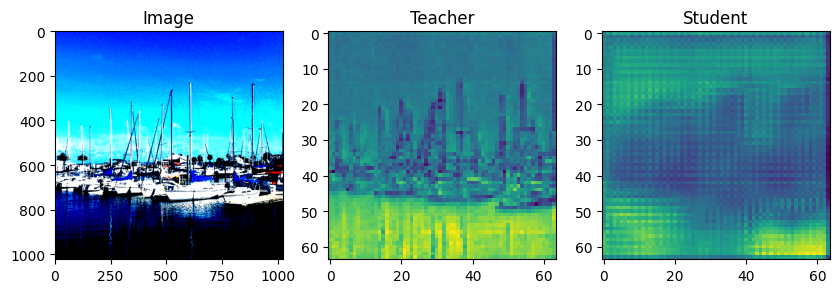

In [23]:
for epoch in range(N_epoch):
    epoch_loss = 0.

    for sample in tqdm(iter(loader)):
        sample = sample.cuda()
        #sample_s = F.interpolate(sample, (512, 512), mode="area")

        ## Teacher model
        with torch.no_grad():
            feat_t = model_t.image_encoder(sample)

        ## Init_gradient
        optimizer.zero_grad()
        
        ## Student model
        feat_s = model_s(sample)

        loss = loss_function(feat_s, feat_t)

        ##update
        loss.backward()
        optimizer.step()
        epoch_loss += float(loss)

    epoch_loss /= len(loader)
    txt1 = f"{epoch} Epoch Loss: {epoch_loss}"
    recoder.add_line(txt1+"\n")
    print(txt1)
    
    torch.save({
        "model": model_s.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch}, output_checkpoint_path)
        
    
    plt.figure(figsize=(10, 10))
    plt.subplot(131)
    plt.title("Image")
    plt.imshow(sample[0].detach().cpu().permute(1, 2, 0))
    plt.subplot(132)
    plt.title("Teacher")
    plt.imshow(feat_t[0, 0].detach().cpu())
    plt.subplot(133)
    plt.title("Student")
    plt.imshow(feat_s[0, 0].detach().cpu())
    plt.savefig(os.path.join(figure_dir, 
                             f"epoch_{str(epoch).zfill(3)}.png"))
    plt.close()

## Visualization

In [14]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(feat_t[0, 0].detach().cpu())
plt.subplot(122)
plt.imshow(feat_s[0, 0].detach().cpu())
plt.savefig(os.path.join(output_checkpoint_dir, 
                         f"epoch_{epoch}.png"))
plt.close()